In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [13]:
sommeil = pd.read_csv("cleanedwpays.csv") #fichier echantillon que je t'ai envoyé
sommeil.drop_duplicates(subset=['PMID'], keep='last', inplace=True)
sommeil = sommeil[sommeil["Pays"]!="Inconnu"]
sommeil = sommeil[sommeil["Pays"]!="Andorra"]


# Fonction de nettoyage des résumés
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"\n+", " ", text)  # Supprimer les retours à la ligne multiples
        text = re.sub(r"\s+", " ", text).strip()  # Supprimer les espaces en trop
    return text

# Appliquer le nettoyage aux résumés
sommeil["Résumé"] = sommeil["Résumé"].apply(clean_text)

sommeil

,Titre,Date de publication,Lien,Résumé,Mots-clés,Auteurs,Affiliations,PMID,Maladie,Auteurs_Affiliations,Pays
0,Sleep characteristics and cerebrospinal fluid ...,2020-08,https://pubmed.ncbi.nlm.nih.gov//32657026/,Introduction: This study tested the self-repor...,alzheimers disease; amyloid cerebrospinal flui...,"Wei Xu, 1, Lan Tan, 1, Bing-Jie Su, 1, Huan Yu...","1 Department of Neurology, Qingdao Municipal H...",32657026,Alzheimer,"[('Wei Xu', ['Department of Neurology, Qingdao...",China
1,Sleep Disturbance and Alzheimer's Disease: The...,2022-07,https://pubmed.ncbi.nlm.nih.gov//35303225/,Poor quality and quantity of sleep are very co...,alzheimer’s disease; amyloid beta; astrocyte; ...,"Aditya Sunkaria, #, 1, Supriya Bhardwaj, #, 2","1 Department of Biotechnology, Guru Nanak Dev ...",35303225,Alzheimer,"[('Aditya Sunkaria', ['Department of Biotechno...",India
2,Association of Sleep With Risk of Alzheimer's ...,2022-04,https://pubmed.ncbi.nlm.nih.gov//34109847/,Objectives: Alzheimer's disease (AD) and relat...,alzheimer’s disease; american association of r...,"Aaron C Schneider, 1, Chooza Moon, 1, Kara Whi...","1 University of Iowa, Iowa City, USA.; 2 The U...",34109847,Alzheimer,"[('Aaron C Schneider', ['University of Iowa, I...",United States
3,Sleep oscillation-specific associations with A...,2019-02,https://pubmed.ncbi.nlm.nih.gov//30791922/,Background: Based on associations between slee...,tau sleep spindle csf density,"Korey Kam, 1, Ankit Parekh, 1, Ram A Sharma, 2...","1 Mount Sinai Integrative Sleep Center, Divisi...",30791922,Alzheimer,"[('Korey Kam', ['Mount Sinai Integrative Sleep...",United States
4,Tailored music listening intervention to reduc...,2020-12,https://pubmed.ncbi.nlm.nih.gov//33136301/,Sleep disruption in older adults living with A...,alzheimers disease; dementia; music; sleep,"Darina V Petrovsky, 1, Nalaka S Gooneratne, 2,...","1 Behavioral Health Sciences Department, Unive...",33136301,Alzheimer,"[('Darina V Petrovsky', ['Behavioral Health Sc...",United States
...,...,...,...,...,...,...,...,...,...,...,...
34959,Comprehensive evaluation of diabetes subtypes ...,2025-02,https://pubmed.ncbi.nlm.nih.gov//40022072/,Background: The traditional binary classificat...,diabetes subtypes; diet; education; exercise; ...,"Nathalie Rohmann, #, 1, 2, Johannes Epe, #, 1,...",1 Institute of Diabetes and Clinical Metabolic...,40022072,Obesite,"[('Nathalie Rohmann', ['Institute of Diabetes ...",Germany
34960,Associations of an overall healthy lifestyle w...,2024-11,https://pubmed.ncbi.nlm.nih.gov//39587552/,Background: Metabolic dysfunction-associated f...,fatty liver disease; hepatic steatosis; lifest...,"Caimei Yuan, #, 1, Chengjing Zhang, #, 2, Xin ...","1 CAS Key Laboratory of Nutrition, Metabolism ...",39587552,Obesite,"[('Caimei Yuan', ['CAS Key Laboratory of Nutri...",China
34961,[Epidemiological characteristics of early-onse...,2024-05,https://pubmed.ncbi.nlm.nih.gov//38778685/,Objective: To explore the differences in distr...,v eocrc patient χ,"T Jin, 1, Y S Zhu, 1, C C Liu, 1, X Xu, 2, W L...","1 Department of Colorectal Surgery, Oncology (...",38778685,Obesite,"[('T Jin', ['Department of Colorectal Surgery,...",China
34963,Factors that influence participation in physic...,2024-06,https://pubmed.ncbi.nlm.nih.gov//38837220/,Background: Mental health problems contribute ...,physical activity health bipolar study,"Claire J McCartan, 1, Jade Yap, 2, Paul Best, ...","1 IMPACT Research Centre, Northern Health & So...",38837220,Obesite,"[('Claire J McCartan', ['IMPACT Research Centr...",United Kingdom


#### Traitement sur mots clés

In [32]:
# Fonction de nettoyage des mots-clés
def nettoyer_texte(texte):
    if pd.isna(texte):
        return ""
    texte = texte.lower()  # Mettre en minuscule
    texte = re.sub(r"\d+", "", texte)  # Supprimer les nombres
    texte = unidecode.unidecode(texte)  # Supprimer les accents
    texte = re.sub(r"[^a-z0-9 ]", "", texte)  # Supprimer les caractères spéciaux
    return texte

som_kmean = sommeil[sommeil["Maladie"]=="Alzheimer"]

# nettoyage des mots-clés
som_kmean["Mots-clés"] = som_kmean["Mots-clés"].apply(nettoyer_texte)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(som_kmean["Mots-clés"])

print(f"Matrice TF-IDF de dimensions: {X.shape}")

# Appliquer K-Means avec k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
som_kmean["Cluster"] = kmeans.fit_predict(X)

som_kmean[["Mots-clés", "Cluster"]].head()

C:\Users\Hendrix\AppData\Local\Temp\ipykernel_18716\2164618372.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  som_kmean["Mots-clés"] = som_kmean["Mots-clés"].apply(nettoyer_texte)


Matrice TF-IDF de dimensions: (2881, 3617)


C:\Users\Hendrix\AppData\Local\Temp\ipykernel_18716\2164618372.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  som_kmean["Cluster"] = kmeans.fit_predict(X)


,Mots-clés,Cluster
0,alzheimers disease amyloid cerebrospinal fluid...,1
1,alzheimers disease amyloid beta astrocyte micr...,1
2,alzheimers disease american association of ret...,1
3,tau sleep spindle csf density,1
4,alzheimers disease dementia music sleep,1


In [33]:
# Réduction de dimension du tf-idf avec PCA en gardant les 2 premieres composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

som_kmean["X_pca"] = X_pca[:, 0]
som_kmean["Y_pca"] = X_pca[:, 1]


C:\Users\Hendrix\AppData\Local\Temp\ipykernel_18716\4278980118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  som_kmean["X_pca"] = X_pca[:, 0]
C:\Users\Hendrix\AppData\Local\Temp\ipykernel_18716\4278980118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  som_kmean["Y_pca"] = X_pca[:, 1]


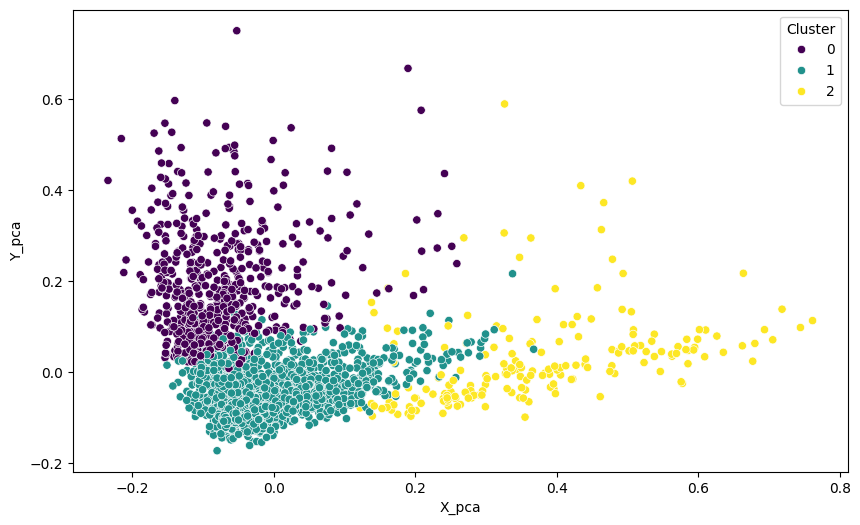

In [39]:
# Plot des clusters avec PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x="X_pca", y="Y_pca", hue=som_kmean["Cluster"], palette="viridis", data=som_kmean)
plt.legend(title="Cluster")
plt.show()

In [43]:
# Récupérer les noms des mots-clés depuis le vectorizer
mc = vectorizer.get_feature_names_out()

# Afficher les mots les plus fréquents par cluster
n_top_words = 5  # Nombre de mots-clés à afficher par cluster
print("Mots-clés les représentatif de chaque cluster")

for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster}:")
    # Trouver les indices des mots ayant les poids les plus élevés dans ce cluster
    top_indices = np.argsort(kmeans.cluster_centers_[cluster])[-n_top_words:]
    top_words = [mc[i] for i in top_indices]
    print(", ".join(top_words))


Mots-clés les représentatif de chaque cluster

Cluster 0:
decline, mild, sleep, impairment, cognitive

Cluster 1:
disorder, alzheimers, dementia, disease, sleep

Cluster 2:
disorder, dementia, with, body, lewy


Le classification des mots-clés n'est pas vraiment exploitable ici, essayons une autre approche

#### Modèle de QA pour répondre directement à la problématique

**exemple avec alzheimer**

In [45]:
# Chargement du modèle de question réponse
qa_pipeline = pipeline("question-answering", model="deepset/bert-large-uncased-whole-word-masking-squad2")

# temps de calcul trop long, on va faire le teste sur les 200 premières lignes
sommeil_qa = sommeil[sommeil["Maladie"]=="Alzheimer"].head(200) 

# Question à poser
question = "What are the impacts of sleep habits on Alzheimer?"

# Appliquer le modèle sur chaque résumé
def extract_answer(row):
    context = row["Résumé"]  # Remplace "résumé" par le nom exact de la colonne
    result = qa_pipeline(question=question, context=context)
    return result["answer"], result["score"]

sommeil_qa["Réponse"], sommeil_qa["Score"] = zip(*sommeil_qa.apply(extract_answer, axis=1))

# Afficher les résultats
sommeil_qa[["Réponse", "Score"]]

# gardons les réponses avec un score de confiance >=0.3
# Filtrer les réponses avec un score >= 0.3
reponse3 = sommeil_qa[sommeil_qa["Score"] >= 0.3]

# Afficher les résultats filtrés
reponse3[["Titre", "Résumé", "Réponse", "Score"]]





Some weights of the model checkpoint at deepset/bert-large-uncased-whole-word-masking-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


,Titre,Résumé,Réponse,Score
2,Association of Sleep With Risk of Alzheimer's ...,Objectives: Alzheimer's disease (AD) and relat...,may contribute to AD risk and mortality,0.376285
4,Tailored music listening intervention to reduc...,Sleep disruption in older adults living with A...,"increased institutionalization, reduced cognit...",0.300154
41,The feasibility of a sleep education program f...,Background: Untreated sleep problems in both p...,health and quality of life,0.392446
59,Subjective cognitive decline symptoms and its ...,Background: Subjective cognitive decline (SCD)...,poor sleep quality,0.888081
65,[Sleep disorders in patients with a neurocogni...,Introduction: Sleep disorders are prevalent in...,Rapid eye movement sleep behavior disorder can...,0.391587
73,Breathing cessation events that compose the ap...,Background: Previous studies challenge the imp...,OSA recognizably disrupts sleep,0.457123
79,"Sleep, physical activity, sedentary behavior, ...","Although sleep, physical activity and sedentar...",lowest dementia risk,0.357901
86,Pareidolias in REM Sleep Behavior Disorder: A ...,Study objectives: To investigate conditions an...,lower sleep efficiency,0.492830
87,Early alterations in the MCH system link aberr...,Early Alzheimer's disease (AD) is associated w...,decreased sleep quality,0.567111
110,"The locus coeruleus neurotoxin, DSP4, and/or a...",Alzheimer's disease (AD) is the sixth leading ...,disruption of sleep patterns are quickly becom...,0.368576


#### nuage de mots

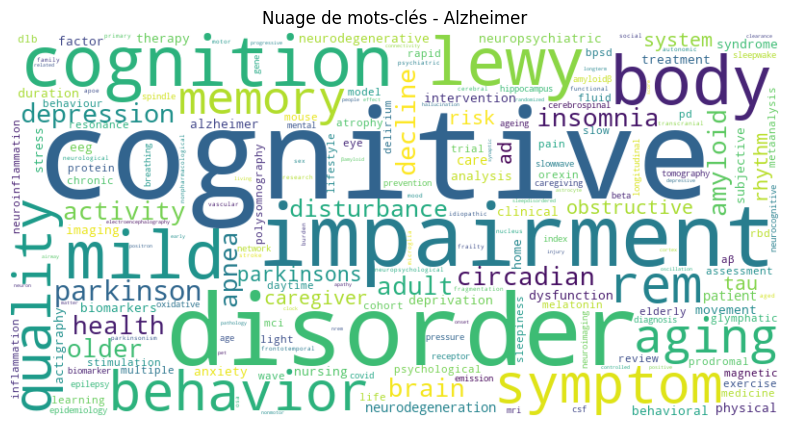

In [65]:
stop_words = set(stopwords.words("english"))

# Ajout dans stopwords de mots pas forcément pertinents
autres_mot = {"alzheimers", "disease", "study", "patients", "results", "conclusions","sleep","p","dementia","participants","function"}
stop_words.update(autres_mot)

# Filtrer les résumés liés à Alzheimer
df_alzheimer = sommeil[sommeil["Maladie"] == "Alzheimer"]["Mots-clés"].dropna()

# Concaténer tous les résumés en un seul texte
texte = " ".join(df_alzheimer)

# Nettoyage basique du texte (supprime la ponctuation et met en minuscules)
texte = re.sub(r"[^\w\s]", "", texte).lower()

# Tokenisation et suppression des stopwords
mots = [mot for mot in texte.split() if mot not in stop_words]

# Comptage des mots
freq_mot = Counter(mots)

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(freq_mot)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots-clés - Alzheimer")
plt.show()
